# Training and evaluation notebook
For binary collapsed classes 0, 1 and 2 into 0, and 4, this one based on bands and VIs.

In [2]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [3]:
# Simply reading the formerly created pickle file, changing it's name to 'merged_df'
# To confirm, you can load and view the combined dataset
with open("combined_dataset.pkl", 'rb') as file:
    merged_df = pd.read_pickle(file)

merged_df


,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2


## 2. Add indices

In [4]:
merged_df['NDVI'] = (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'])

# EVI is an optimized vegetation index designed to enhance the vegetation signal with improved sensitivity in high biomass regions
# It's calculated using the Red (B4), Near-Infrared (B8 or B5), and Blue (B2) bands.
merged_df['EVI'] = 2.5 * (merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + 6 * merged_df['B4'] - 7.5 * merged_df['B2'] + 1)

# NDWI is used to monitor changes in water content of leaves
# It is typically calculated using the Near-Infrared (B8 or B5) and Short-Wave Infrared (B11 or B6) bands.
merged_df['NDWI'] = (merged_df['B8'] - merged_df['B11']) / (merged_df['B8'] + merged_df['B11'])

# SAVI is a modification of NDVI to correct for the influence of soil brightness
# The standard value of L in the SAVI formula is 0.5.
L = 0.5  # soil brightness correction factor
merged_df['SAVI'] = ((merged_df['B8'] - merged_df['B4']) / (merged_df['B8'] + merged_df['B4'] + L)) * (1 + L)

# GNDVI is used to estimate vegetation health
# It's calculated using the Near-Infrared (B8 or B5) and Green (B3) bands.
merged_df['GNDVI'] = (merged_df['B8'] - merged_df['B3']) / (merged_df['B8'] + merged_df['B3'])

merged_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2,0.568914,0.246737,-0.052386,0.271183,0.670018
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2,0.581259,0.287926,-0.015721,0.308070,0.688819
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2,0.834221,0.731688,0.337125,0.652436,0.765506
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2,0.776236,0.581962,0.247564,0.544852,0.721622
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2,0.830017,0.746039,0.372873,0.664865,0.767403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2,0.516930,0.319632,-0.031002,0.321629,0.602862
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2,0.625818,0.443384,0.076328,0.432730,0.637691
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2,0.484021,0.294097,-0.044519,0.296020,0.571209
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2,0.602697,0.397850,0.009969,0.393631,0.653291


In [5]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

In the following, I will make some new dataframes for binary classification:

In [6]:
# Step 1: Create a new DataFrame for binary classification
# First, filter out class 3, then collapse classes 0, 1, and 2 into 0.
binary_df = merged_df[merged_df['classes'].isin([0, 1, 2, 4])]
binary_df.loc[binary_df['classes'].isin([0, 1, 2]), 'classes'] = 0

Dropping columns:

In [7]:
binary_df = binary_df.drop('sample_location_id', axis=1)

In [8]:
# Assuming merged_df is your pandas DataFrame
# Shuffle the DataFrame using a random seed, for example, seed=42
binary_df = binary_df.sample(frac=1, random_state=42).reset_index(drop=True)
binary_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes,NDVI,EVI,NDWI,SAVI,GNDVI
0,0.03440,0.0407,0.0646,0.0718,0.1222,0.20300,0.2303,0.2618,0.2672,0.2448,0.24540,0.1302,4,0.569544,0.342379,0.032334,0.341891,0.604167
1,0.03890,0.0361,0.0440,0.0609,0.0943,0.13680,0.1612,0.1779,0.1899,0.2191,0.25770,0.1609,0,0.489950,0.229853,-0.183196,0.237547,0.603425
2,0.03040,0.0384,0.0658,0.0421,0.1247,0.34040,0.4195,0.4156,0.4835,0.4696,0.22420,0.1009,0,0.816037,0.676532,0.299156,0.584995,0.726631
3,0.03560,0.0440,0.0616,0.0730,0.1289,0.19880,0.2284,0.2456,0.2668,0.2672,0.28880,0.1660,0,0.541745,0.318780,-0.080838,0.316272,0.598958
4,0.01920,0.0440,0.0682,0.0553,0.1340,0.30050,0.3457,0.3756,0.4086,0.2304,0.22980,0.1123,0,0.743328,0.581349,0.240833,0.516113,0.692654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096431,0.04060,0.0419,0.0549,0.0668,0.1226,0.20600,0.2362,0.2702,0.2836,0.2701,0.25570,0.1412,4,0.603561,0.374793,0.027572,0.364516,0.662258
1096432,0.02790,0.0327,0.0620,0.0499,0.1269,0.27580,0.3239,0.3592,0.3802,0.3341,0.21140,0.1023,0,0.756050,0.547104,0.259026,0.510340,0.705603
1096433,0.03400,0.0420,0.0575,0.0677,0.1048,0.17110,0.1987,0.2266,0.2301,0.2169,0.22240,0.1283,4,0.539925,0.301449,0.009354,0.300076,0.595213
1096434,0.02255,0.0175,0.0405,0.0228,0.0991,0.20825,0.2438,0.2220,0.2634,0.2628,0.17935,0.0919,0,0.813726,0.405686,0.106266,0.401182,0.691429


## Constructing training and test sets
Here I include 'stratify' to make sure that the proportions of class 0 and 4 are equal in each set (seeing that there are many more 0 values than 4)

In [9]:
from sklearn.model_selection import train_test_split

# Assuming your features are all columns except 'classes', and 'classes' is the target variable
X = binary_df.drop('classes', axis=1)  # Features
y = binary_df['classes']  # Target variable

# Perform the split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# X_train and y_train will now contain 70% of the data, X_test and y_test will contain 30%
# Both splits will have the same proportion of class 0 and 4 as the original dataset

## Hyperparameter optimisation

In [11]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    # Ensuring min_samples_split is an int >= 2
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    # Ensuring min_samples_leaf is a float within (0.0, 0.5], you could also use suggest_int if you want specific integer values
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Initialize the classifier with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the validation set
    predictions = clf.predict(X_test)

    # Compute and return the accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

In [12]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print(f"Best trial: {study.best_trial.params}")

[I 2024-02-12 19:50:06,675] A new study created in memory with name: no-name-66124ce2-5c2b-49e6-bda6-3f4ebe4d27bf
[I 2024-02-12 20:01:43,015] Trial 0 finished with value: 0.7986203793500765 and parameters: {'n_estimators': 239, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7986203793500765.
[I 2024-02-12 20:19:27,574] Trial 1 finished with value: 0.8311135162085665 and parameters: {'n_estimators': 193, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8311135162085665.
[I 2024-02-12 20:26:47,860] Trial 2 finished with value: 0.8127814040026632 and parameters: {'n_estimators': 114, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8311135162085665.
[I 2024-02-12 20:29:46,484] Trial 3 finished with value: 0.792132696522979 and parameters: {'n_estimators': 243, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0

Best trial: {'n_estimators': 152, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 4}


## Training and evaluating

First a logistic regression model:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000) # Increase max_iter if convergence warnings occur

# Train the classifier on the training set
log_reg.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg.predict(X_test)

# Predict on the test set
lr_predictions = log_reg.predict(X_test)

# Calculate metrics, specifying pos_label for binary classification
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')
lr_kappa = cohen_kappa_score(y_test, lr_predictions)

# Print metrics
print("Logistic Regression Performance:")
print(f"Precision: {lr_precision}")
print(f'Logistic Regression Accuracy: {log_reg_accuracy}')
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")
print(f"Cohen's Kappa: {lr_kappa}")

Logistic Regression Performance:
Precision: 0.7532691719277133
Logistic Regression Accuracy: 0.7843468691002065
Recall: 0.7843468691002065
F1 Score: 0.726842263840487
Cohen's Kappa: 0.1547639987429047


### RF model based on both bands and VIs:

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Best trial: {'n_estimators': 152, 'max_depth': 31, 'min_samples_split': 2, 'min_samples_leaf': 4}

# Assuming you have your optimized hyperparameters, for example:
optimized_hyperparameters = {
    'n_estimators': 152,
    'max_depth': 31,
    'min_samples_split': 2,
    'min_samples_leaf': 4, 
    # Include other hyperparameters as necessary
}

# Initialize the RandomForestClassifier with optimized hyperparameters
clf = RandomForestClassifier(
    n_estimators=optimized_hyperparameters['n_estimators'],
    max_depth=optimized_hyperparameters['max_depth'],
    min_samples_split=optimized_hyperparameters['min_samples_split'],
    min_samples_leaf=optimized_hyperparameters['min_samples_leaf'],
    random_state=42  # Ensuring reproducibility
)

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the test set
predictions = clf.predict(X_test)

# Compute and display the accuracy
accuracy = accuracy_score(y_test, predictions)
rf_precision = precision_score(y_test, predictions, average='weighted')
rf_recall = recall_score(y_test, predictions, average='weighted')
rf_f1 = f1_score(y_test, predictions, average='weighted')
rf_kappa = cohen_kappa_score(y_test, predictions)

# Print metrics
print("RandomForest Performance:")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")
print(f"Cohen's Kappa: {rf_kappa}")
print(f'Optimized RandomForest Accuracy: {accuracy}')

RandomForest Performance:
Precision: 0.9373996734186807
Recall: 0.9363757140555314
F1 Score: 0.9336451635521202
Cohen's Kappa: 0.8047684995317339
Optimized RandomForest Accuracy: 0.9363757140555314


## Confusion matrix

- You'll also want to output an aggregated prediction confusion matrix (from the cross-validation), preferably as a seaborn (sns) figure. 

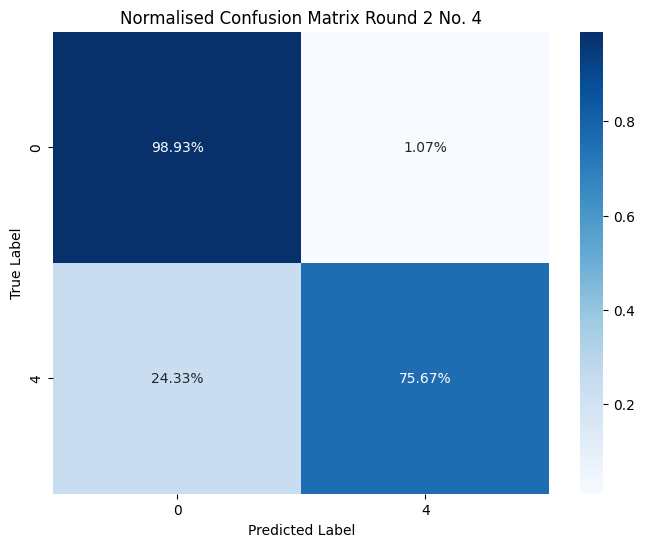

In [16]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions, y_test are already defined

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, predictions, labels=[0, 4], normalize='true')

# Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=[0, 4], yticklabels=[0, 4])
plt.title('Normalised Confusion Matrix Round 2 No. 4')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Feature permutation importance

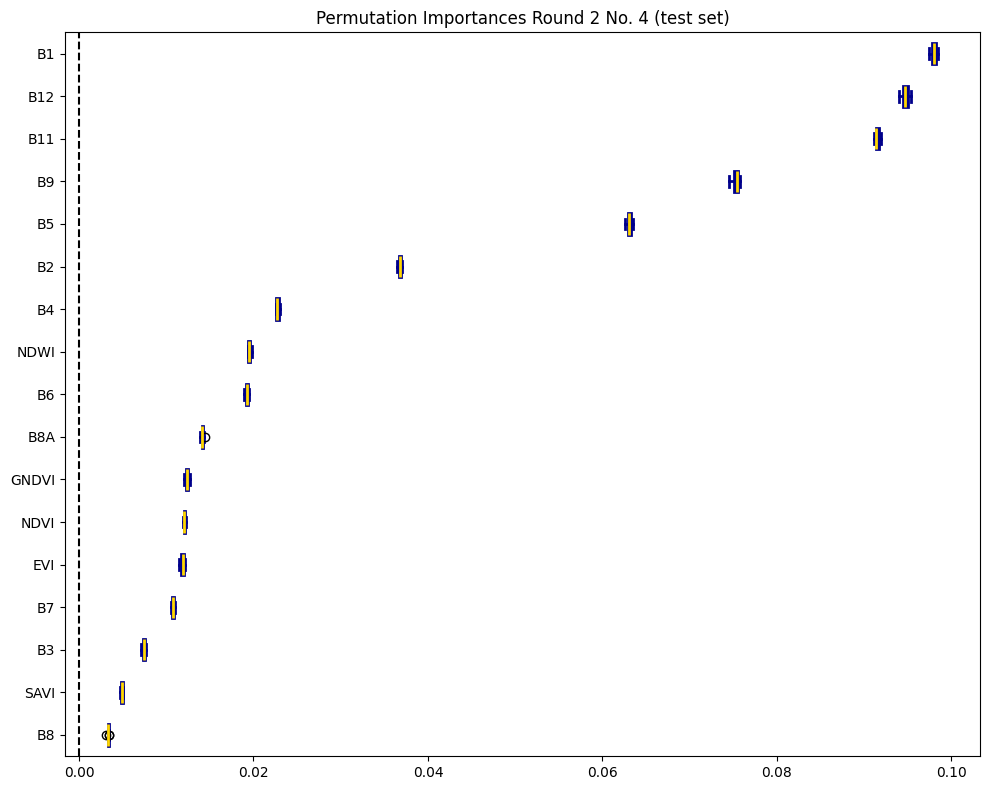

In [18]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assuming clf is your trained RandomForestClassifier model
# and X_test, y_test are your test datasets

result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

# Sorting features by importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 8))
bp = ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx],
                patch_artist=True,  # To fill with color
                )

# Customizing the boxplot color to dark green
for box in bp['boxes']:
    # Change box color
    box.set(color='darkblue', linewidth=2)  # Box edge color
    box.set(facecolor='darkblue')  # Box fill color

# Optionally, customize whiskers, fliers, caps, and medians if needed
for whisker in bp['whiskers']:
    whisker.set(color='darkblue', linewidth=2)
for cap in bp['caps']:
    cap.set(color='darkblue', linewidth=2)
for median in bp['medians']:
    median.set(color='gold', linewidth=2)  # Making the median stand out

ax.axvline(x=0, color="k", linestyle="--")
ax.set_title("Permutation Importances Round 2 No. 4 (test set)")
plt.tight_layout()
plt.show()